# Autocoder

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
import cv2  # 確保安裝了OpenCV




#設定資料夾路徑
allblackwhite_dir = './allblackwhite'
pymatting_outcome_rw_dir = './pymatting_outcome_rw'

# #讀取圖片和標籤
# def load_images_from_folder(folder):
#     images = []
#     for filename in os.listdir(folder):
#         img = load_img(os.path.join(folder, filename), color_mode='grayscale', target_size=(256, 256))
#         if img is not None:
#             img_array = img_to_array(img)
#             images.append(img_array)
#     return np.array(images)

# 讀取圖片和標籤
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, (128, 128))  # 使用OpenCV將圖片大小調整為32x32
            images.append(img_resized)
    return np.array(images)

x = load_images_from_folder(allblackwhite_dir)
y = load_images_from_folder(pymatting_outcome_rw_dir)

#資料分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42) #資料分割一定要按照x_train, x_test, y_train, y_test此順序



#重塑圖片維度
x_train = x_train.reshape((x_train.shape[0], 128, 128, 1))
y_train = y_train.reshape((y_train.shape[0], 128, 128, 1))
x_test = x_test.reshape((x_test.shape[0], 128, 128, 1))
y_test = y_test.reshape((y_test.shape[0], 128, 128, 1))

#標準化圖片 
x_train = x_train.astype('float32') / (255.0)   #每一格裡面的數值/255(像素數值)，並不是說總共有幾格
y_train = y_train.astype('float32') / (255.0)
x_test = x_test.astype('float32') / (255.0)
y_test = y_test.astype('float32') / (255.0)

# # 將 numpy 陣列轉換為 tf.data.Dataset(shuffle 和 batch 是 tf.data.Dataset 物件的方法)
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# train_dataset = train_dataset.shuffle(batchsz * 5).batch(batchsz)
# test_dataset = test_dataset.batch(batchsz)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(270, 128, 128, 1) (270, 128, 128, 1)
(31, 128, 128, 1) (31, 128, 128, 1)


In [2]:
latent_dim = 256   #隱藏層神經元個數

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(128*128, activation='sigmoid'), #Autoencoder使用sigmoid當激活函數
            layers.Reshape((128, 128))
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [3]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())  #用MSE
history = autoencoder.fit(x_train, y_train,     #輸入輸出都是自己(期望輸出會和自己一樣)
                epochs=50,
                shuffle=True,
                validation_data=(x_test, y_test))

Epoch 1/50
9/9 [==============================] - 1s 55ms/step - loss: 0.1143 - val_loss: 0.0217
Epoch 2/50
9/9 [==============================] - 0s 53ms/step - loss: 0.0212 - val_loss: 0.0216
Epoch 3/50
9/9 [==============================] - 0s 48ms/step - loss: 0.0206 - val_loss: 0.0211
Epoch 4/50
9/9 [==============================] - 0s 47ms/step - loss: 0.0198 - val_loss: 0.0200
Epoch 5/50
9/9 [==============================] - 0s 46ms/step - loss: 0.0182 - val_loss: 0.0182
Epoch 6/50
9/9 [==============================] - 0s 51ms/step - loss: 0.0170 - val_loss: 0.0175
Epoch 7/50
9/9 [==============================] - 1s 57ms/step - loss: 0.0162 - val_loss: 0.0169
Epoch 8/50
9/9 [==============================] - 0s 49ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 9/50
9/9 [==============================] - 0s 48ms/step - loss: 0.0152 - val_loss: 0.0159
Epoch 10/50
9/9 [==============================] - 0s 48ms/step - loss: 0.0148 - val_loss: 0.0158
Epoch 11/50
9/9 [============

In [4]:
# 創建保存模型的目錄
save_dir = 'test_model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存模型為 TensorFlow SavedModel 格式
autoencoder.save(os.path.join(save_dir, 'saved_model'), save_format='tf')

# 加載模型
loaded_model = tf.keras.models.load_model(os.path.join(save_dir, 'saved_model'))

INFO:tensorflow:Assets written to: test_model\saved_model\assets


INFO:tensorflow:Assets written to: test_model\saved_model\assets


In [5]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

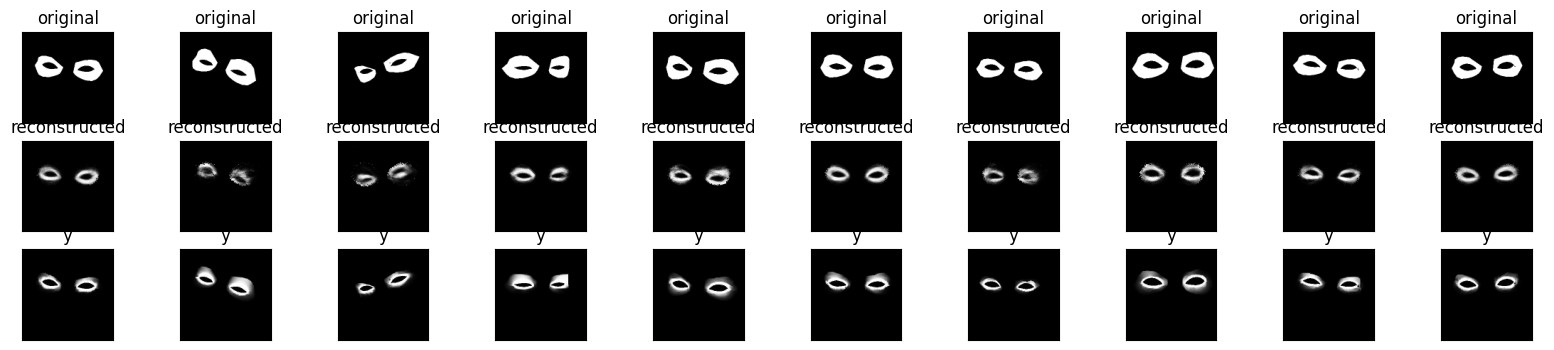

In [6]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)        #(3列,一列有n個圖,編號(index+1))
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(y_test[i])
    plt.title("y")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# VAE

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import cv2  # 確保安裝了OpenCV



tf.random.set_seed(9)
np.random.seed(9)



def save_images(imgs, name):             #存照片def
    grid_size = int(np.ceil(np.sqrt(len(imgs)))) * 128  # 自動計算所需網格大小
    new_im = Image.new('L', (grid_size, grid_size))

    index = 0
    for i in range(0, grid_size, 128):
        for j in range(0, grid_size, 128):
            if index >= len(imgs):
                break
            im = imgs[index]
            im = Image.fromarray(im, mode='L')
            new_im.paste(im, (i, j))
            index += 1

    new_im.save(name)


h_dim = 256        #隱藏層維度
batchsz = 90      #批次
lr = 1e-3         #學習率


#設定資料夾路徑
allblackwhite_dir = './allblackwhite'
pymatting_outcome_rw_dir = './pymatting_outcome_rw'

# 讀取圖片和標籤
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, (128, 128))  # 使用OpenCV將圖片大小調整為32x32
            images.append(img_resized)
    return np.array(images)

x = load_images_from_folder(allblackwhite_dir)
y = load_images_from_folder(pymatting_outcome_rw_dir)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42) #資料分割一定要按照x_train, x_test, y_train, y_test此順序x

#重塑圖片維度
x_train = x_train.reshape((x_train.shape[0], 128, 128, 1))
y_train = y_train.reshape((y_train.shape[0], 128, 128, 1))
x_test = x_test.reshape((x_test.shape[0], 128, 128, 1))
y_test = y_test.reshape((y_test.shape[0], 128, 128, 1))

#標準化圖片 
x_train = x_train.astype('float32') / (255.0)   #每一格裡面的數值/255(像素數值)，並不是說總共有幾格
y_train = y_train.astype('float32') / (255.0)
x_test = x_test.astype('float32') / (255.0)
y_test = y_test.astype('float32') / (255.0)


# 將 numpy 陣列轉換為 tf.data.Dataset(shuffle 和 batch 是 tf.data.Dataset 物件的方法)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(batchsz * 5).batch(batchsz)
test_dataset = test_dataset.batch(batchsz)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


#資料分割

(270, 128, 128, 1) (270, 128, 128, 1)
(31, 128, 128, 1) (31, 128, 128, 1)


In [9]:
z_dim = 64

class VAE(keras.Model):

    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = layers.Dense(256)
        self.fc2 = layers.Dense(z_dim) # get mean prediction
        self.fc3 = layers.Dense(z_dim) #fc2、fc3一個預測平均向量另一個預測標準差向量

        # Decoder
        self.fc4 = layers.Dense(256)
        self.fc5 = layers.Dense(128*128)  #28*28

    def encoder(self, x):

        h = tf.nn.relu(self.fc1(x))
        # get mean
        mu = self.fc2(h)       #平均向量
        # get variance
        log_var = self.fc3(h)  #標準差向量

        return mu, log_var

    def decoder(self, z):

        out = tf.nn.relu(self.fc4(z)) #將隱向量(z)decoder
        out = self.fc5(out)    #輸出照片

        return out

    def reparameterize(self, mu, log_var):   #計算隱向量

        eps = tf.random.normal(log_var.shape)

        std = tf.exp(log_var*0.5)

        z = mu + std * eps   #講義23-18   由平均、標準差、noise向量計算隱向量 z
        return z

    def call(self, inputs, training=None):   #執行VAE模型

        # [b, 784] => [b, z_dim], [b, z_dim]
        mu, log_var = self.encoder(inputs) #將照片輸入encoder預測平均和標準差向量
        # reparameterization trick
        z = self.reparameterize(mu, log_var) #計算隱向量

        x_hat = self.decoder(z)  #將隱向量(z)decoder輸出照片向量

        return x_hat, mu, log_var


model = VAE()
model.build(input_shape=(90, 128*128))
optimizer = tf.optimizers.Adam(lr)

for epoch in range(1000):

    for step, (x,y) in enumerate(train_dataset):  #step:批次數  x:照片

        x = tf.reshape(x, [-1, 128*128])  #將x重新塑形->[自動計算,28*28]
        y = tf.reshape(y, [-1, 128*128])  # 将 y 重新塑形为 [batch_size, 1024]

        with tf.GradientTape() as tape:
            x_rec_logits, mu, log_var = model(x)

            rec_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_rec_logits)
            rec_loss = tf.reduce_sum(rec_loss) / x.shape[0]

            # compute kl divergence (mu, var) ~ N (0, 1)
            # https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
            kl_div = -0.5 * (log_var + 1 - mu**2 - tf.exp(log_var))
            kl_div = tf.reduce_sum(kl_div) / x.shape[0]

            loss = rec_loss + 1. * kl_div   #講義23-19

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))


        if step % 100 == 0:
            print(epoch, step, 'kl div:', float(kl_div), 'rec loss:', float(rec_loss))


    # evaluation
    z = tf.random.normal((batchsz, z_dim))
    logits = model.decoder(z)
    x_hat = tf.sigmoid(logits)
    x_hat = tf.reshape(x_hat, [-1, 128, 128]).numpy() *255.
    x_hat = x_hat.astype(np.uint8)
    # save_images(x_hat, 'vae_images/sampled_epoch%d.png'%epoch)

    x, y = next(iter(test_dataset))
    x = tf.reshape(x, [-1, 128*128])
    x_hat_logits, _, _ = model(x)
    x_hat = tf.sigmoid(x_hat_logits)
    x_hat = tf.reshape(x_hat, [-1, 128, 128]).numpy() *255.
    x_hat = x_hat.astype(np.uint8)
    # save_images(x_hat, 'vae_images/rec_epoch%d.png'%epoch)


0 0 kl div: 7.236085414886475 rec loss: 11369.2353515625
1 0 kl div: 2594.824951171875 rec loss: 6384.8251953125
2 0 kl div: 912.7428588867188 rec loss: 3364.14990234375
3 0 kl div: 794.2531127929688 rec loss: 2919.615234375
4 0 kl div: 563.3607788085938 rec loss: 2460.161865234375
5 0 kl div: 407.3612060546875 rec loss: 2477.958251953125
6 0 kl div: 287.7105407714844 rec loss: 2450.6806640625
7 0 kl div: 222.49032592773438 rec loss: 2345.093017578125
8 0 kl div: 202.34188842773438 rec loss: 2379.45751953125
9 0 kl div: 184.8060760498047 rec loss: 2138.29296875
10 0 kl div: 167.12100219726562 rec loss: 2041.4517822265625
11 0 kl div: 166.731201171875 rec loss: 1947.658203125
12 0 kl div: 173.04739379882812 rec loss: 1887.2540283203125
13 0 kl div: 163.0267791748047 rec loss: 1872.5809326171875
14 0 kl div: 156.7767791748047 rec loss: 1777.9481201171875
15 0 kl div: 160.12057495117188 rec loss: 1826.9996337890625
16 0 kl div: 153.41647338867188 rec loss: 1633.079833984375
17 0 kl div: 1

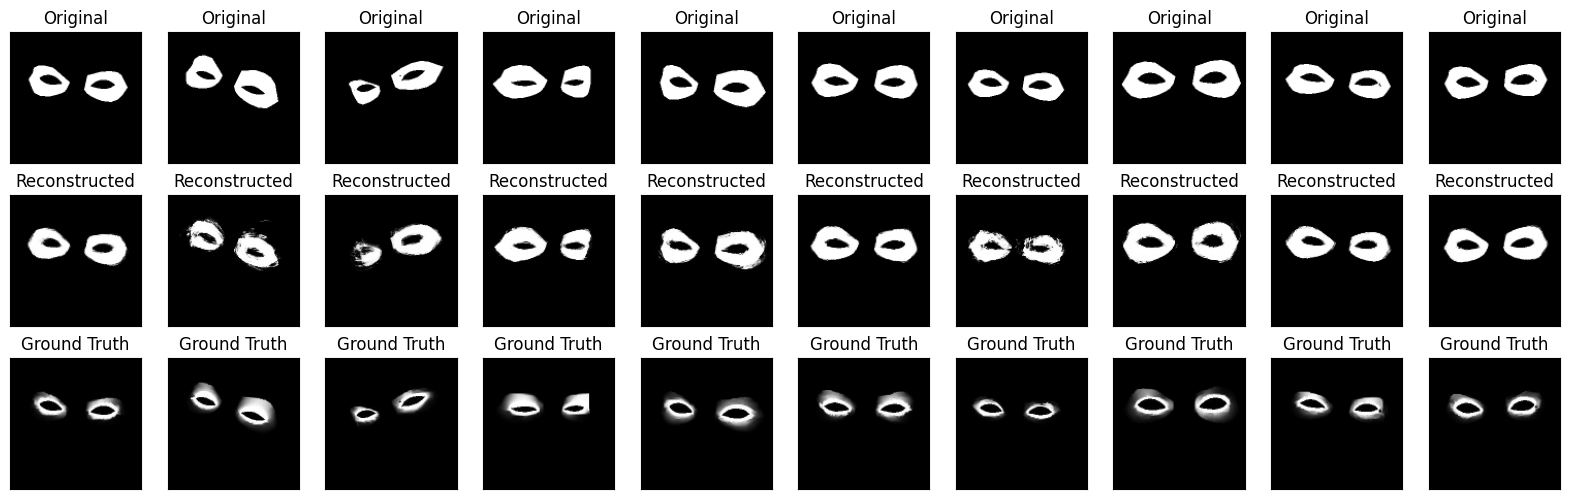

In [10]:
# 測試模型並視覺化
def visualize_results(model, x_test, y_test, n=10):
    # 將 x_test reshape 成 (batch_size, 128*128)
    x_test_reshaped = tf.reshape(x_test, [-1, 128*128])
    
    # 獲得編碼結果
    mu, log_var = model.encoder(x_test_reshaped)
    z = model.reparameterize(mu, log_var)
    decoded_imgs_logits = model.decoder(z)
    
    # 將解碼結果 reshape 成 (batch_size, 128, 128, 1)
    decoded_imgs = tf.sigmoid(decoded_imgs_logits)
    decoded_imgs = tf.reshape(decoded_imgs, [-1, 128, 128, 1])
    
    # 將結果轉換回 numpy array
    decoded_imgs = decoded_imgs.numpy() * 255
    decoded_imgs = decoded_imgs.astype(np.uint8)
    
    # 可視化結果
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # 原始圖片
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i].reshape(128, 128), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # 重建圖片
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(128, 128), cmap='gray')
        plt.title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # 地面真值圖片
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(y_test[i].reshape(128, 128), cmap='gray')
        plt.title("Ground Truth")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

# 可視化測試結果
visualize_results(model, x_test, y_test, n=10)

# DenseNet

Epoch 1/50
9/9 [==============================] - 28s 2s/step - loss: 0.1488 - val_loss: 0.0224
Epoch 2/50
9/9 [==============================] - 14s 2s/step - loss: 0.0204 - val_loss: 0.0202
Epoch 3/50
9/9 [==============================] - 14s 2s/step - loss: 0.0197 - val_loss: 0.0199
Epoch 4/50
9/9 [==============================] - 14s 2s/step - loss: 0.0193 - val_loss: 0.0190
Epoch 5/50
9/9 [==============================] - 14s 2s/step - loss: 0.0187 - val_loss: 0.0188
Epoch 6/50
9/9 [==============================] - 14s 2s/step - loss: 0.0182 - val_loss: 0.0188
Epoch 7/50
9/9 [==============================] - 14s 2s/step - loss: 0.0178 - val_loss: 0.0182
Epoch 8/50
9/9 [==============================] - 14s 2s/step - loss: 0.0175 - val_loss: 0.0179
Epoch 9/50
9/9 [==============================] - 14s 2s/step - loss: 0.0171 - val_loss: 0.0177
Epoch 10/50
9/9 [==============================] - 14s 2s/step - loss: 0.0168 - val_loss: 0.0174
Epoch 11/50
9/9 [======================

INFO:tensorflow:Assets written to: densenet_model\saved_model\assets


INFO:tensorflow:Assets written to: densenet_model\saved_model\assets


1/1 [==============================] - 1s 1s/step


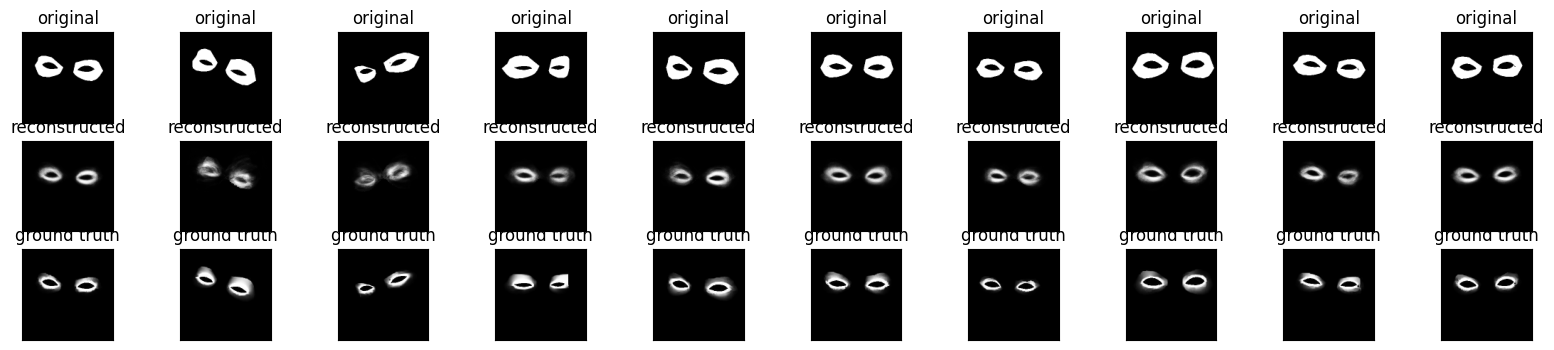

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses, Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import cv2

# 設定資料夾路徑
allblackwhite_dir = './allblackwhite'
pymatting_outcome_rw_dir = './pymatting_outcome_rw'

# 讀取圖片和標籤
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, (128, 128))
            images.append(img_resized)
    return np.array(images)

x = load_images_from_folder(allblackwhite_dir)
y = load_images_from_folder(pymatting_outcome_rw_dir)

# 資料分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# 重塑圖片維度
x_train = x_train.reshape((x_train.shape[0], 128, 128, 1))
y_train = y_train.reshape((y_train.shape[0], 128, 128, 1))
x_test = x_test.reshape((x_test.shape[0], 128, 128, 1))
y_test = y_test.reshape((y_test.shape[0], 128, 128, 1))

# 標準化圖片 
x_train = x_train.astype('float32') / 255.0
y_train = y_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_test = y_test.astype('float32') / 255.0

# 建立DenseNet模型
def build_densenet(input_shape):
    base_model = DenseNet121(include_top=False, weights=None, input_shape=input_shape)
    base_model.trainable = True

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128 * 128, activation='sigmoid')(x)
    outputs = layers.Reshape((128, 128, 1))(x)
    
    model = Model(inputs, outputs)
    return model

input_shape = (128, 128, 1)
densenet_model = build_densenet(input_shape)
densenet_model.compile(optimizer=Adam(), loss=losses.MeanSquaredError())

# 訓練模型
densenet_model.fit(x_train, y_train, epochs=50, shuffle=True, validation_data=(x_test, y_test))

# 创建保存模型的目录
save_dir = 'densenet_model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存模型为 TensorFlow SavedModel 格式
densenet_model.save(os.path.join(save_dir, 'saved_model'), save_format='tf')

# 加载模型
loaded_model = tf.keras.models.load_model(os.path.join(save_dir, 'saved_model'))

# 使用加载的模型进行预测
decoded_imgs = loaded_model.predict(x_test)

# 可视化结果
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128), cmap='gray')
    plt.title("original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128), cmap='gray')
    plt.title("reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(y_test[i].reshape(128, 128), cmap='gray')
    plt.title("ground truth")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
